In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import seaborn as sns
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
class AgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

        self.age_ranges = [
            "0-4",   "5-9",   "10-14", "15-19", "20-24",  "25-29", 
            "30-34", "35-39", "40-44", "45-49", "50-54",  "55-59",
            "60-64", "65-69", "70-74", "75-79", "80-84",  "85-89",
            "90-94", "95-99", "100-104","105-109","110-114","115-119"
        ]
        self.age_to_index = {age_str: i for i, age_str in enumerate(self.age_ranges)}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 1) Parse the pixel data
        pixel_str = self.data.iloc[idx]["pixels"]
        pixels = np.array(pixel_str.split(), dtype=np.float32)
        
        if len(pixels) != 48 * 48:
            raise ValueError(
                f"Expected 2304 pixels, got {len(pixels)} for index {idx}."
            )

        pixels = torch.tensor(pixels).view(1, 48, 48)

        age_range_str = self.data.iloc[idx]["label"]
        age_index = self.age_to_index[age_range_str]  
        
        return pixels, age_index


In [4]:
age_train = AgeDataset("age-train.csv")
loader_train = DataLoader(age_train, batch_size=32, shuffle=True, num_workers=2)

age_val = AgeDataset("age-val.csv")
loader_val = DataLoader(age_val, batch_size=32, shuffle=True, num_workers=2)

age_test = AgeDataset("age-test.csv")
loader_test = DataLoader(age_test, batch_size=32, shuffle=True, num_workers=2)

In [5]:
def check_accuracy(loader, model, device = 'cuda', dtype=torch.float32):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            
            loss = F.cross_entropy(scores, y, reduction='sum')
            total_loss += loss.item()
            
            _, preds = scores.max(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [6]:
def train(model, optimizer, loader_train, loader_val, epochs=1, device='cuda', dtype=torch.float32):
    model = model.to(device=device)

    train_epochs = []
    train_losses = []
    train_accuracies = []
    
    val_epochs = []
    val_losses = []
    val_accuracies = []

    num_batches_per_epoch = len(loader_train)  
    half_epoch_interval = num_batches_per_epoch // 2  

    iteration = 0  

    for epoch in range(epochs):
        model.train()
        for batch_idx, (x, y) in enumerate(loader_train):
            iteration += 1

            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = scores.max(dim=1)
            batch_acc = (preds == y).float().mean().item()

            if (batch_idx + 1) % half_epoch_interval == 0:
                epoch_progress = epoch + (batch_idx + 1) / num_batches_per_epoch 
                
                val_loss, val_acc = check_accuracy(loader_val, model, device, dtype)

                train_epochs.append(epoch_progress)
                train_losses.append(loss.item())
                train_accuracies.append(batch_acc)

                val_epochs.append(epoch_progress)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

                print(f"Epoch [{epoch_progress:.1f}/{epochs}], "
                      f"Train Loss: {loss.item():.4f}, Train Acc: {batch_acc*100:.2f}% "
                      f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    final_val_loss, final_val_acc = check_accuracy(loader_val, model, device, dtype)
    print(f"Finished training. Final val loss = {final_val_loss:.4f}, val acc = {final_val_acc*100:.2f}%")

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_epochs, train_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1,2,2)
    plt.plot(train_epochs, train_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(val_epochs, val_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')

    plt.subplot(1,2,2)
    plt.plot(val_epochs, val_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

    return final_val_loss, final_val_acc

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        # Shortcut
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=24):
        super(ResNet, self).__init__()
        # For grayscale input: in_channels = 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = nn.Sequential(
            Block(64, 64, stride=1),
            Block(64, 64, stride=1)
        )
        self.layer2 = nn.Sequential(
            Block(64, 128, stride=2),
            Block(128, 128, stride=1)
        )
        self.layer3 = nn.Sequential(
            Block(128, 256, stride=2),
            Block(256, 256, stride=1)
        )
        self.layer4 = nn.Sequential(
            Block(256, 512, stride=2),
            Block(512, 512, stride=1)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Epoch [0.5/10], Train Loss: 1.9364, Train Acc: 37.50% | Val Loss: 2.2624, Val Acc: 27.98%
Epoch [1.0/10], Train Loss: 2.0935, Train Acc: 34.38% | Val Loss: 2.1001, Val Acc: 30.51%
Epoch [1.5/10], Train Loss: 2.0369, Train Acc: 40.62% | Val Loss: 2.0970, Val Acc: 30.29%
Epoch [2.0/10], Train Loss: 2.0104, Train Acc: 28.12% | Val Loss: 1.9855, Val Acc: 32.40%
Epoch [2.5/10], Train Loss: 1.8662, Train Acc: 40.62% | Val Loss: 1.9634, Val Acc: 32.62%
Epoch [3.0/10], Train Loss: 1.9402, Train Acc: 34.38% | Val Loss: 1.9707, Val Acc: 32.99%
Epoch [3.5/10], Train Loss: 1.8829, Train Acc: 28.12% | Val Loss: 1.9260, Val Acc: 32.54%
Epoch [4.0/10], Train Loss: 1.9606, Train Acc: 40.62% | Val Loss: 1.9245, Val Acc: 33.04%
Epoch [4.5/10], Train Loss: 1.7734, Train Acc: 31.25% | Val Loss: 1.9457, Val Acc: 32.23%
Epoch [5.0/10], Train Loss: 1.6728, Train Acc: 46.88% | Val Loss: 1.9065, Val Acc: 34.06%
Epoch [5.5/10], Train Loss: 2.1224, Train Acc: 43.75% | Val Loss: 1.9096, Val Acc: 33.61%
Epoch [6.0

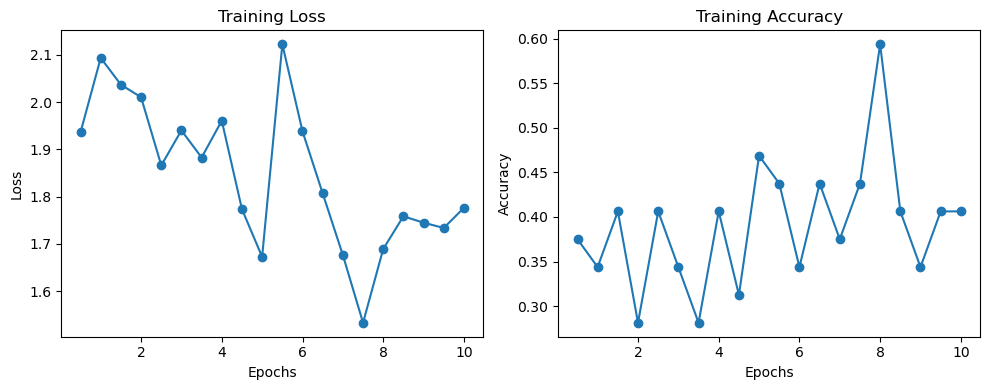

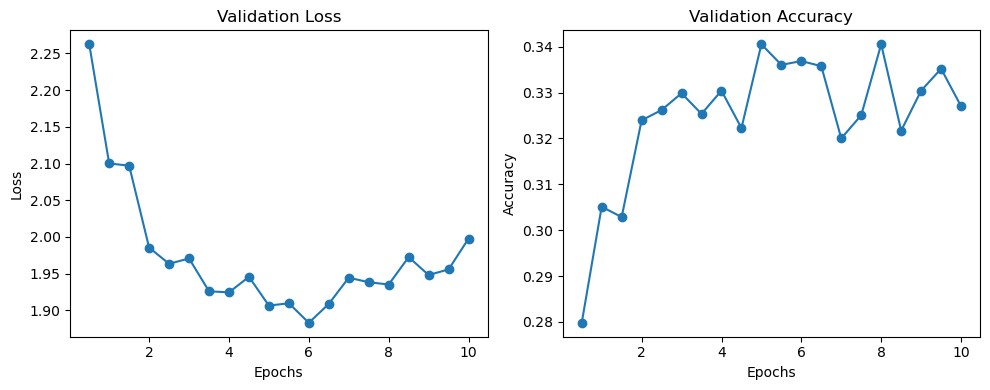

In [8]:
model = ResNet(num_classes=24)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

final_accuracy = train(model, optimizer, loader_train, loader_val, epochs=10)

In [9]:
test_loss, test_acc = check_accuracy(loader_test, model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Test Loss: 1.9887, Test Accuracy: 33.24%


In [18]:
def plot_confusion_matrix(model, dataloader, class_names, device='cuda'):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Age Group")
    plt.ylabel("Actual Age Group")
    plt.title("Confusion Matrix")
    plt.show()


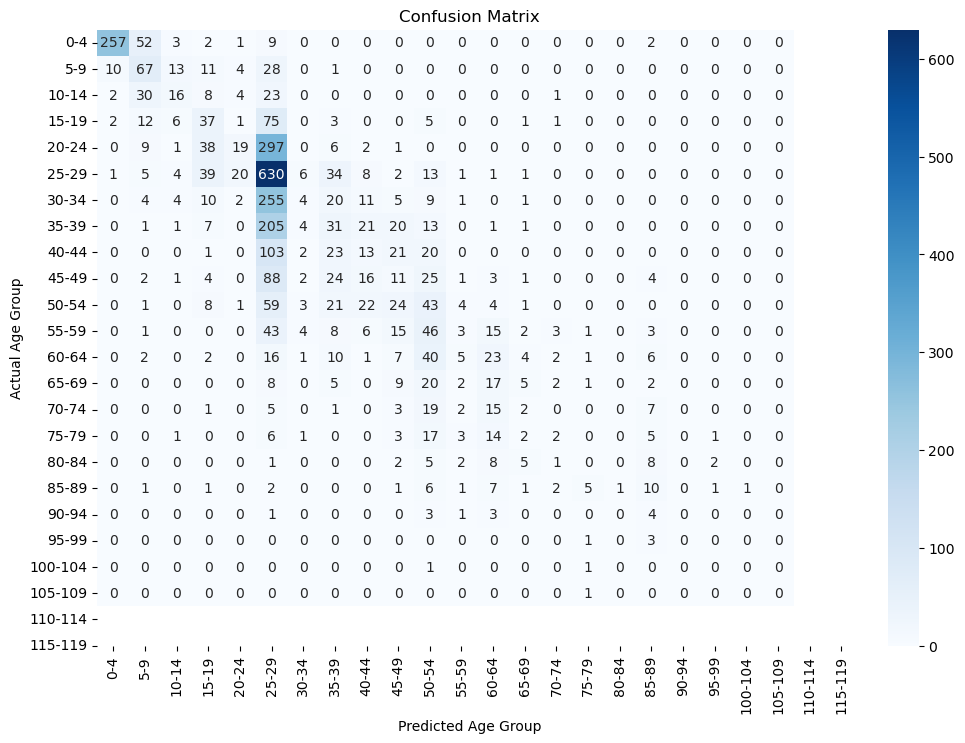

In [19]:
age_ranges = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29",
    "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",
    "60-64", "65-69", "70-74", "75-79", "80-84", "85-89",
    "90-94", "95-99", "100-104", "105-109", "110-114", "115-119"
]
plot_confusion_matrix(model, loader_val, class_names=age_ranges)